In [1]:
import pickle
import datetime

import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import hsv_to_rgb
from tensorboardX import SummaryWriter
from scipy.stats import multivariate_normal

from helpers import PushingDataset

# Data loading
- Load csv into three separate pytorch "DataLoader"s, train, validation, and test.

In [2]:
def plot_transition(d, rotate=False):
    
    if rotate:
        d = d.copy()
        
        # translate
        dx, dy = d[['y0', 'y1']]
        d[['x0', 'y0', 'y_0']] -= dx
        d[['x1', 'y1', 'y_1']] -= dy
        
        # rotate
        θ = -d['y2']
        for prefix in ['x', 'x_', 'y_', 'u', 'y']:
            x = d[prefix + '0'].copy()
            y = d[prefix + '1'].copy()
            d[prefix + '0'] = np.cos(θ) * x - np.sin(θ) * y
            d[prefix + '1'] = np.sin(θ) * x + np.cos(θ) * y
            if prefix is not 'u':
                d[prefix + '2'] += θ

    k = 0.05
    head_width=0.02
    plt.arrow(d['x0'], d['x1'],  k * np.cos(d['x2']), k * np.sin(d['x2']), head_width=head_width, color='black')
    plt.arrow(d['x0'], d['x1'], -k * np.sin(d['x2']), k * np.cos(d['x2']), head_width=head_width, color='black')
    
    plt.arrow(d['x_0'], d['x_1'],  k * np.cos(d['x_2']), k * np.sin(d['x_2']), head_width=head_width, color='grey')
    plt.arrow(d['x_0'], d['x_1'], -k * np.sin(d['x_2']), k * np.cos(d['x_2']), head_width=head_width, color='grey')

    plt.arrow(d['y0'], d['y1'],  k * np.cos(d['y2']), k * np.sin(d['y2']), head_width=head_width, color='red')
    plt.arrow(d['y0'], d['y1'], -k * np.sin(d['y2']), k * np.cos(d['y2']), head_width=head_width, color='red')

    plt.arrow(d['y_0'], d['y_1'],  k * np.cos(d['y_2']), k * np.sin(d['y_2']), head_width=head_width, color='pink')
    plt.arrow(d['y_0'], d['y_1'], -k * np.sin(d['y_2']), k * np.cos(d['y_2']), head_width=head_width, color='pink')

    t = d['u3']
    plt.arrow(d['x0'], d['x1'],  t * d['u0'], t * d['u1'], head_width=0.03, color='blue')

    plt.xlim(-1.0, 1.0)
    plt.ylim(-1.0, 1.0)
    plt.grid()

In [3]:
files_folder = 'dual_point_multi_size_1'
columns=['x0','x1','x2','y0',
         'y1','y2','x_0','x_1',
         'x_2','y_0','y_1','y_2',
         'u0','u1','u2','u3',
         'u4','w','h','m',
         'I','µ','type']
dataset = pd.read_csv('training_data/{}/train/random_data_0'.format(files_folder), names=columns)
print(dataset[['w', 'h', 'm', 'µ']].min())
print(dataset[['w', 'h', 'm', 'µ']].max())

w    0.080502
h    0.080502
m    0.100451
µ    0.100045
dtype: float64
w    0.119970
h    0.119970
m    0.199695
µ    0.199982
dtype: float64


In [4]:
mask = (
    (dataset['y_0'] == dataset['y0']) &
    (dataset['y_1'] == dataset['y1'])
)
non_moving = dataset[mask][['y0', 'y1', 'y2', 'y_0', 'y_1', 'y_2']]
sub_dataset = dataset.drop(non_moving.sample(frac=0.9).index)

In [5]:
dataset = sub_dataset

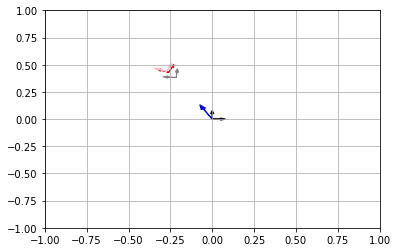

In [6]:
i = np.random.randint(0, len(sub_dataset))
plot_transition(sub_dataset.iloc[i])
plt.show()

In [7]:
dataset_train = sub_dataset.iloc[:int(0.8 * sub_dataset.shape[0])]
dataset_val = sub_dataset.iloc[int(0.8 * sub_dataset.shape[0]):int(0.9 * sub_dataset.shape[0])]
dataset_test = sub_dataset.iloc[int(0.9 * sub_dataset.shape[0]):]

In [8]:
train_size = 512

pushing_dataset_train = PushingDataset('training_data/{}/train'.format(files_folder))
pushing_dataset_val = PushingDataset('training_data/{}/valid'.format(files_folder))
dataloader_train = DataLoader(pushing_dataset_train, batch_size=train_size, drop_last=True, num_workers=8, worker_init_fn=pushing_dataset_train.worker_init)
dataloader_val = DataLoader(pushing_dataset_val, batch_size=1024, drop_last=True)

In [9]:
train_iter = iter(dataloader_train)
#valid_iter = iter(dataloader_val)
next(train_iter)[-1]


 0.3058  0.2381 -0.2280  0.9737
 0.3079 -0.2237 -0.9940 -0.1091
-0.6575  0.0973 -0.1949 -0.9808
               ⋮                
-0.1357 -0.2294 -0.6265 -0.7794
 0.0602  0.0645  0.3394 -0.9407
 0.2764  0.3859  0.6559 -0.7548
[torch.FloatTensor of size 512x4]

# Define models
- Separate mean and variance models, for stability
- MSE loss for the mean, gaussian log likelihood for the variance
- Learn: $p(u|x_r, x_t, x_t')$

In [10]:
class Normalization(torch.nn.Module):
    
    def __init__(self, n_features):
        super(Normalization, self).__init__()
        self.register_buffer('mean', torch.zeros(n_features))
        self.register_buffer('std', torch.ones(n_features))
        
    def forward(self, x):
        y = (x - Variable(self.mean)) / (Variable(self.std) + 1e-9)
        return y.clamp(-5, 5)
    
class NormalizationInverse(torch.nn.Module):
    
    def __init__(self, n_features):
        super(NormalizationInverse, self).__init__()
        self.register_buffer('mean', torch.zeros(n_features))
        self.register_buffer('std', torch.ones(n_features))
        
    def forward(self, x):
        return x * Variable(self.std) + Variable(self.mean)

In [11]:
def normalizers(mini_batch):
    mean = mini_batch.mean(dim=0)
    std = mini_batch.std(dim=0) + 1e-9
    norm = Normalization(mean.size(0))
    norm_inv = NormalizationInverse(mean.size(0))
    norm.mean = norm_inv.mean = torch.FloatTensor(mean)
    norm.std = norm_inv.std = torch.FloatTensor(std)
    return norm.cuda(), norm_inv.cuda()

X, U, Y = next(iter(dataloader_train))
norm_x, norminv_x = normalizers(X)
norm_u, norminv_u = normalizers(U)
norm_y, norminv_y = normalizers(Y)
norm_y.mean *= 0.0
norminv_y.mean *= 0.0

In [12]:
class Residual(torch.nn.Module):
    
    def __init__(self, num_features):
        super(Residual, self).__init__()
        self.bn1 = torch.nn.BatchNorm1d(num_features)
        self.fc1 = torch.nn.Linear(num_features, num_features)
        self.bn2 = torch.nn.BatchNorm1d(num_features)
        self.fc2 = torch.nn.Linear(num_features, num_features)
        
    def forward(self, x):
        a = self.fc1(F.relu(self.bn1(x)))
        b = self.fc2(F.relu(self.bn2(a)))
        return b + x

In [13]:
class RewardFCPlain(torch.nn.Module):
    
    def __init__(self, x_size, u_size, y_size, hidden_units=256):
        super(RewardFCPlain, self).__init__()
        
        self.sequential = torch.nn.Sequential(
            torch.nn.Linear(x_size + u_size, hidden_units),
            torch.nn.BatchNorm1d(hidden_units),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_units, hidden_units),
            torch.nn.BatchNorm1d(hidden_units),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_units, hidden_units),
            torch.nn.BatchNorm1d(hidden_units),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_units, hidden_units),
            torch.nn.BatchNorm1d(hidden_units),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_units, y_size)  # E[Y]
        )
        
    def forward(self, x, u):
        xu = torch.cat([x, u], dim=1)
        y = self.sequential(xu)                    # E(Y)
        # Var(Y) = E(Y^2) - E(Y)^2
        # E(Y^2) = Var(Y) + E(Y)^2
        # y2 = F.softplus(self.fcy2(a2)) + y ** 2 # E(Y^2)
        # t = F.softplus(self.fct(a2))
        return y

class FCPositive(torch.nn.Module):
    
    def __init__(self, x_size, u_size, y_size, hidden_units=256):
        super(FCPositive, self).__init__()
        
        self.sequential = torch.nn.Sequential(
            torch.nn.Linear(x_size + u_size, hidden_units),
            torch.nn.BatchNorm1d(hidden_units),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_units, hidden_units),
            torch.nn.BatchNorm1d(hidden_units),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_units, hidden_units),
            torch.nn.BatchNorm1d(hidden_units),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_units, hidden_units),
            torch.nn.BatchNorm1d(hidden_units),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_units, y_size),
            torch.nn.Softplus()
        )
        
    def forward(self, x, u):
        xu = torch.cat([x, u], dim=1)
        y = self.sequential(xu)
        return y
    
X, U, Y = next(iter(dataloader_val))
X, U, Y = map(lambda x: Variable(x.cuda()), [X, U, Y])
reward = RewardFCPlain(X.size(1), U.size(1), Y.size(1)).cuda()

In [14]:
reward.eval()
X, U, Y = next(iter(dataloader_val))
reward(Variable(X.cuda()), Variable(U.cuda()))

Variable containing:
1.00000e-02 *
-5.3692 -5.7688  0.4484 -3.1995
-5.3130 -5.7611  0.4909 -3.2412
-5.2868 -5.6989  0.4271 -3.2114
               ⋮                
-5.3626 -5.8037  0.4828 -3.2188
-5.3741 -5.7248  0.4809 -3.2362
-5.2393 -5.7122  0.4854 -3.2454
[torch.cuda.FloatTensor of size 1024x4 (GPU 0)]

In [15]:
dataset_train.__len__()

37572

In [16]:
logger_train = SummaryWriter('runs/dual-point-train')
logger_valid = SummaryWriter('runs/dual-point-valid')
optim_mean = torch.optim.Adam(reward.parameters(), weight_decay=1e-3, betas=(0.99, 0.999))
loss_fn = torch.nn.MSELoss()
best_val = np.inf
best_models = None
step = -1
n_steps = 30000

while True:
    for X, U, Y in dataloader_train:
        reward.train()
        step += 1
        X, U, Y = map(lambda x: Variable(x.cuda()), [X, U, Y])
        X, U, Y = norm_x(X), norm_u(U), norm_y(Y)
        Y_pred = reward(X, U)
        reward.zero_grad()
        loss_mean = loss_fn(Y_pred, Y)
        loss_mean.backward()
        optim_mean.step()

        if step % 50 == 0:
            logger_train.add_scalar('mean', loss_mean.cpu().data[0], step)
            
            # validation
            reward.eval()
            X, U, Y = next(iter(dataloader_val))
            X, U, Y = map(lambda x: Variable(x.cuda()), [X, U, Y])
            X, U, Y = norm_x(X), norm_u(U), norm_y(Y)
            Y_pred = reward(X, U)
            loss_mean = loss_fn(Y_pred, Y)
            logger_valid.add_scalar('mean', loss_mean.cpu().data[0], step)
            val_loss = loss_mean.cpu().data[0]
            if val_loss < best_val:
                best_val = val_loss
                best_models = reward.state_dict(),
        if step > n_steps:
            break
    if step > n_steps:
        break

In [ ]:
reward.eval()
reward.load_state_dict(best_models[0])

X, U, Y = next(iter(dataloader_val))
X, U, Y = map(lambda x: Variable(x.cuda()), [X, U, Y])
variance = FCPositive(X.size(1), U.size(1), Y.size(1)).cuda()
optim_variance = torch.optim.Adam(variance.parameters(), weight_decay=1e-3)
best_val = np.inf
best_variance_model = None
step = -1
n_steps = 50000

def loss_fn(Y, mean_pred, var_pred):
    N = Y.size(0)
    y_err = Y - mean_pred
    nll = (torch.log(var_pred).sum() + (y_err ** 2 / var_pred).sum()) / N
    return nll

while True:
    for X, U, Y in dataloader_train:
        variance.train()
        step += 1
        X, U, Y = map(lambda x: Variable(x.cuda()), [X, U, Y])
        X, U, Y = norm_x(X), norm_u(U), norm_y(Y)
        Y_pred = reward(X, U)
        Y2_pred = variance(X, U)
        variance.zero_grad()
        loss_variance = loss_fn(Y, Y_pred.detach(), Y2_pred)
        loss_variance.backward()
        optim_variance.step()

        if step % 50 == 0:
            logger_train.add_scalar('loss_variance', loss_variance.cpu().data[0], step)
            
            # validation
            variance.eval()
            X, U, Y = next(iter(dataloader_val))
            X, U, Y = map(lambda x: Variable(x.cuda()), [X, U, Y])
            X, U, Y = norm_x(X), norm_u(U), norm_y(Y)
            Y_pred = reward(X, U)
            Y2_pred = variance(X, U)
            loss_variance = loss_fn(Y, Y_pred.detach(), Y2_pred)
            logger_valid.add_scalar('loss_variance', loss_variance.cpu().data[0], step)
            val_loss = loss_variance.cpu().data[0]
            if val_loss < best_val:
                best_val = val_loss
                best_variance_model = variance.state_dict()
        if step > n_steps:
            break
    if step > n_steps:
        break

In [22]:
reward.eval()
variance.eval()
X, U, Y = next(iter(dataloader_val))
X, U, Y = map(lambda x: Variable(x.cuda()), [X, U, Y])
X[:1, :3], norminv_y(reward(norm_x(X), norm_u(U)))[:1, :], Y[:1, :]

(Variable containing:
  0.0003 -0.2863  1.5148
 [torch.cuda.FloatTensor of size 1x3 (GPU 0)], Variable containing:
 -0.0025 -0.2925  0.0472  0.9862
 [torch.cuda.FloatTensor of size 1x4 (GPU 0)], Variable containing:
  0.0143 -0.2729  0.0560  0.9984
 [torch.cuda.FloatTensor of size 1x4 (GPU 0)])

In [23]:
variance.eval()
variance.load_state_dict(best_variance_model)
#with open('notebook_models/reward.pkl', 'wb') as f:
#    pickle.dump(reward.state_dict(), f)
#with open('notebook_models/variance.pkl', 'wb') as f:
#    pickle.dump(variance.state_dict(), f)
#X, U, Y = next(iter(dataloader_val))
#X, U, Y = map(lambda x: Variable(x.cuda()), [X, U, Y])
#X, U, Y = norm_x(X)[:1, :], norm_u(U)[:1, :], norm_y(Y)[:1, :]

In [13]:
with open('notebook_models/reward.pkl', 'rb') as f:
    reward.load_state_dict(pickle.load(f))
with open('notebook_models/variance.pkl', 'rb') as f:
    variance.load_state_dict(pickle.load(f))

In [24]:
class ExpectedDistance(torch.nn.Module):
    
    def __init__(self, mean_model, variance_model):
        super(ExpectedDistance, self).__init__()
        self.mean = mean_model
        self.variance = variance_model
        self.register_buffer(
            'weights',
            torch.FloatTensor([1.0, 1.0, 0.1, 0.1])
        )
        
    def forward(self, x, u, g):
        """
        Variables should all be normalized!
        Goal is relative object! G_rel = (G - X)
        Goal is normalized with same as Y = (X' - X)
        """
        mean = self.mean(x, u)
        var = self.variance(x, u)
        return ((var + (mean - g) ** 2) * Variable(self.weights)).mean(dim=1)
    
expect_distance = ExpectedDistance(reward, variance).cuda()
X, U, Y = next(iter(dataloader_val))
X, U, Y = map(lambda x: Variable(x.cuda()), [X, U, Y])
norm_x = norm_x.cuda()
norm_u = norm_u.cuda()
norm_y = norm_y.cuda()
expect_distance(norm_x(X), norm_u(U), norm_y(Y))

Variable containing:
 0.0048
 0.0087
 0.0498
   ⋮   
 0.0081
 0.0049
 0.0042
[torch.cuda.FloatTensor of size 1024 (GPU 0)]

Variable containing:
 0.1985
 0.4508
 0.0626
[torch.cuda.FloatTensor of size 3 (GPU 0)]
 Variable containing:
-0.0485
 0.4626
-1.2707
 0.0196
[torch.cuda.FloatTensor of size 4 (GPU 0)]
 Variable containing:
 0.2083
 0.4549
 0.9980
 0.0625
[torch.cuda.FloatTensor of size 4 (GPU 0)]



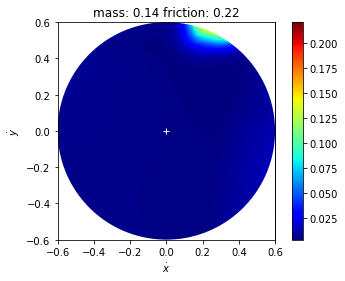

In [25]:
def plot_q(π=None, X=None, G=None, duration=0.6, mass=0.10, friction=0.05):
    reward.eval()
    variance.eval()
    obj_x = 0.0; obj_y = -0.3
    width = 0.10
    if X is None:
        X = Variable(torch.cuda.FloatTensor([[obj_x, obj_y, 0.0, width, width, mass, friction]]))
    else:
        X = X[:1, :]
        mass = X[0, -2].cpu().data[0]
        friction = X[0, -1].data[0]
    _, U, Y = next(iter(dataloader_val))
    U = Variable(U.cuda())[:1, :]
    g = 0.2 * np.array([obj_x, obj_y, 0.0]) / np.sqrt(obj_x ** 2 + obj_y ** 2)
    if G is None:
        G = Variable(torch.cuda.FloatTensor(g)).resize(1, 3)
    else:
        G = G[:1, :]
    if π:
        U = π(norm_x(X), norm_y(G)).cpu().data.numpy().flatten()
        duration = float(U[-1])
    U = Variable(torch.cuda.FloatTensor([[0.0, 0.0, 0.0, duration]]))
    
    res = 32
    u_range = 0.6
    img = np.zeros((res, res))
    img_var = np.zeros((res, res))
    min_dist = np.inf
    min_x_y = None
    for i, ux in enumerate(np.linspace(-u_range, u_range, res)):
        for j, uy in enumerate(np.linspace(-u_range, u_range, res)):
            U[0, 0] = ux
            U[0, 1] = uy
            d = expect_distance(norm_x(X), norm_u(U), norm_y(G)).cpu().data[0]
            img[j, i] = d
            if d < min_dist:
                min_dist = d
                min_x_y = (ux, uy)
            
    fig, ax = plt.subplots(figsize=(6, 4))
    if π:
        U = π(norm_x(X), norm_y(G)).cpu().data.numpy().flatten()
        plt.plot(U[0], U[1], 'ko', markersize=5.0)
        plt.plot(U[0], U[1], 'wo', markersize=4.0)
    #plt.plot(*min_x_y, 'ko', markersize=5.0)
    #plt.plot(*min_x_y, 'wo', markersize=4.0)
    circle = plt.Circle((0, 0), radius=u_range + 0.69, fill=False, linewidth=250, color='white')
    mappable = ax.imshow(img, extent=[-u_range, u_range, -u_range, u_range], origin='lower', interpolation='gaussian', cmap='jet')
    ax.add_artist(circle)
    ax.plot(0, 0, 'w+')
    ax.set_title('mass: {:.2f} friction: {:.2f}'.format(mass, friction))
    ax.set_xlabel('$\dot{x}$')
    ax.set_ylabel('$\dot{y}$')
    plt.colorbar(mappable=mappable)
    #plt.savefig('mass{}friction{}.png'.format(mass, friction))
    plt.show()

val_iter = iter(dataloader_val)
X, U, Y = next(val_iter)
X, U, Y = map(lambda x: Variable(x.cuda()), [X, U, Y])
print(X[0, :3], U[0], Y[0])
plot_q(X=X, G=Y)
#plot_q(friction=0.05, mass=0.05)
#plot_q(friction=0.1, mass=0.1)
#plot_q(friction=0.2, mass=0.4)

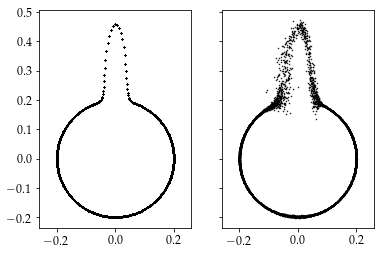

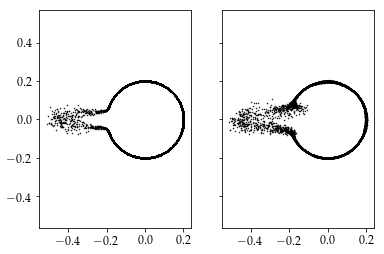

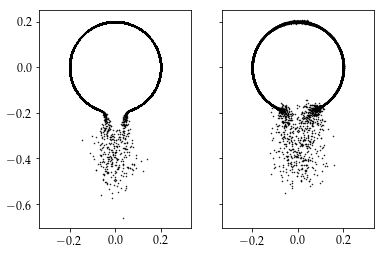

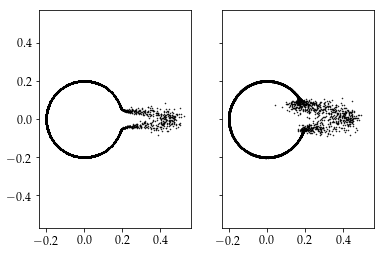

In [785]:
from mock_data import propagate


one_direction = True

reward.eval()
variance.eval()
for action_angle in [np.pi / 2, np.pi, -np.pi / 2, 0.0]:
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
    od = 0.2
    ad = 0.4
    mass = 0.05
    size = 0.1
    friction = 0.05
    n_samples = 400
    xs = np.zeros((n_samples, 2))
    X = torch.zeros(n_samples, 7).cuda()
    U = torch.zeros(n_samples, 4).cuda()
    
    # prediction
    for i, θ in enumerate(np.linspace(-np.pi, np.pi, n_samples)):
        X[i, :] = torch.cuda.FloatTensor([[od * np.cos(θ), od * np.sin(θ), 0.0, size, size, mass, friction]])
        if one_direction:
            U[i, :] = torch.cuda.FloatTensor([[ad * np.cos(action_angle), ad * np.sin(action_angle), 0.0, 0.6]])
        else:
            U[i, :] = torch.cuda.FloatTensor([[ad * np.cos(θ), ad * np.sin(θ), 0.0, 0.6]])
        xs[i, 0] = od * np.cos(θ)
        xs[i, 1] = od * np.sin(θ)
    y_delta = norminv_y(reward(norm_x(Variable(X)), norm_u(Variable(U)))).cpu().data.numpy()
    mean = X.cpu().numpy()[:, :2] + y_delta[:, :2]
    std = norminv_y(variance(norm_x(Variable(X)), norm_u(Variable(U))) ** 0.5).cpu().data.numpy()
    for _ in range(16):
        ax[1].plot(mean[:, 0] + np.random.randn(n_samples) * std[:, 0], mean[:, 1] + np.random.randn(n_samples) * std[:, 1], 'k.', markersize=1.0)
    #ax[1].plot(xs[:, 0], xs[:, 1], 'k.', markersize=1.0)
    ax[1].axis('equal')

    # ground truth
    xs = np.zeros((n_samples, 2))
    for i, θ in enumerate(np.linspace(0, 2 * np.pi, n_samples)):
        obj = np.array([[np.cos(θ) * od, np.sin(θ) * od, 0.0, mass, friction, size, size]] * 16) 
        if one_direction:
            action = np.array([[np.cos(action_angle) * ad, np.sin(action_angle) * ad, 0.0, 0.6]] * 16) 
        else:
            action = np.array([[np.cos(θ) * ad, np.sin(θ) * ad, 0.0, 0.6]] * 16) 
        ys = propagate(obj, action)
        obj_ = obj[:, :3] + ys
        xs[i, :] = np.array([obj[0, 0], obj[0, 1]])
        ax[0].plot(obj_[:, 0], obj_[:, 1], 'k.', markersize=1.0)
    #ax[0].plot(xs[:, 0], xs[:, 1], 'k')
    ax[0].axis('equal')
    plt.show()
    if not one_direction:
        break


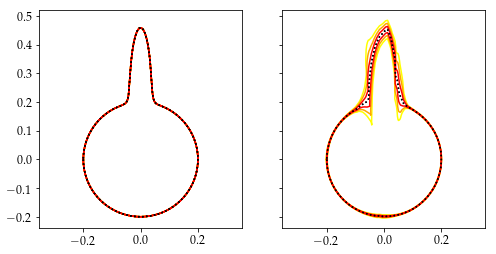

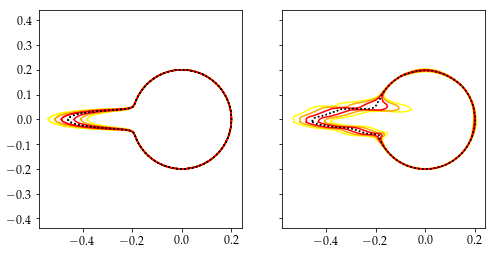

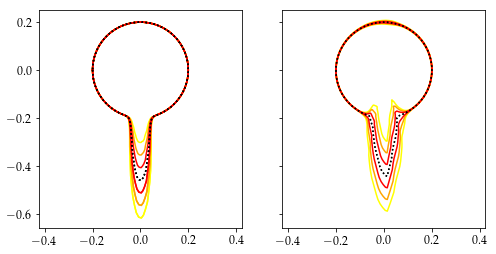

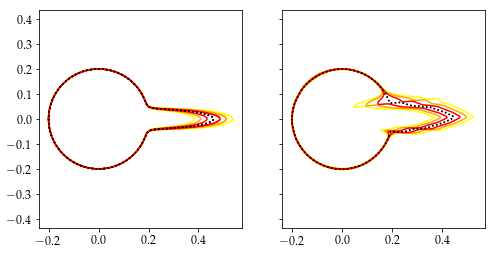

In [787]:
from mock_data import propagate


one_direction = True

reward.eval()
variance.eval()
for action_angle in [np.pi / 2, np.pi, -np.pi / 2, 0.0]:
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 4))
    od = 0.2
    ad = 0.4
    mass = 0.05
    size = 0.1
    friction = 0.05
    n_samples = 400
    xs = np.zeros((n_samples, 2))
    X = torch.zeros(n_samples, 7).cuda()
    U = torch.zeros(n_samples, 4).cuda()
    
    # prediction
    θs = np.linspace(-np.pi, np.pi, n_samples)
    for i, θ in enumerate(θs):
        X[i, :] = torch.cuda.FloatTensor([[od * np.cos(θ), od * np.sin(θ), 0.0, size, size, mass, friction]])
        if one_direction:
            U[i, :] = torch.cuda.FloatTensor([[ad * np.cos(action_angle), ad * np.sin(action_angle), 0.0, 0.6]])
        else:
            U[i, :] = torch.cuda.FloatTensor([[ad * np.cos(θ), ad * np.sin(θ), 0.0, 0.6]])
        xs[i, 0] = od * np.cos(θ)
        xs[i, 1] = od * np.sin(θ)
    y_delta = norminv_y(reward(norm_x(Variable(X)), norm_u(Variable(U)))).cpu().data.numpy()
    mean = X.cpu().numpy()[:, :2] + y_delta[:, :2]
    std = norminv_y(variance(norm_x(Variable(X)), norm_u(Variable(U))) ** 0.5).cpu().data.numpy()
    for n_stds, color in reversed([(0, 'k'), (1, 'red'), (2, 'orange'), (3, 'yellow')]):
        if n_stds == 0:
            linestyle = ':'
        else:
            linestyle = '-'
        ax[1].plot(mean[:, 0] + n_stds * np.cos(θs) * std[:, 0], mean[:, 1] + n_stds * np.sin(θs) * std[:, 1], color=color, linestyle=linestyle)
        ax[1].plot(mean[:, 0] - n_stds * np.cos(θs) * std[:, 0], mean[:, 1] - n_stds * np.sin(θs) * std[:, 1], color=color, linestyle=linestyle)
        plt.plot()
    #ax[1].plot(xs[:, 0], xs[:, 1], 'k.', markersize=1.0)
    ax[1].axis('equal')

    # ground truth
    n_samples_gt = 4096
    mean = np.zeros((n_samples, 2))
    std = np.zeros((n_samples, 2))
    for i, θ in enumerate(θs):
        obj = np.array([[np.cos(θ) * od, np.sin(θ) * od, 0.0, mass, friction, size, size]] * n_samples_gt) 
        if one_direction:
            action = np.array([[np.cos(action_angle) * ad, np.sin(action_angle) * ad, 0.0, 0.6]] * n_samples_gt) 
        else:
            action = np.array([[np.cos(θ) * ad, np.sin(θ) * ad, 0.0, 0.6]] * n_samples_gt) 
        ys = propagate(obj, action)
        obj_ = obj[:, :3] + ys
        mean[i, :] = np.array([obj_[:, 0].mean(), obj_[:, 1].mean()])
        std[i, :] = np.array([obj_[:, 0].std(), obj_[:, 1].std()])
        #ax[0].plot(obj_[:, 0], obj_[:, 1], 'k.', markersize=1.0)
    for n_stds, color in reversed([(0, 'k'), (1, 'red'), (2, 'orange'), (3, 'yellow')]):
        if n_stds == 0:
            linestyle = ':'
        else:
            linestyle = '-'
        ax[0].plot(mean[:, 0] + n_stds * np.cos(θs) * std[:, 0], mean[:, 1] + n_stds * np.sin(θs) * std[:, 1], color=color, linestyle=linestyle)
        ax[0].plot(mean[:, 0] - n_stds * np.cos(θs) * std[:, 0], mean[:, 1] - n_stds * np.sin(θs) * std[:, 1], color=color, linestyle=linestyle)
        ax[0].plot(mean[:, 0] + n_stds * np.cos(θs) * std[:, 0], mean[:, 1] + n_stds * np.sin(θs) * std[:, 1], color=color, linestyle=linestyle)
    ax[0].axis('equal')
    plt.show()
    if not one_direction:
        break


In [21]:
with open('notebook_models/mock/reward.pt', 'rb') as f:
    reward.load_state_dict(pickle.load(f))
with open('notebook_models/mock/variance.pt', 'rb') as f:
    variance.load_state_dict(pickle.load(f))
with open('notebook_models/mock/norm_x.pt', 'rb') as f:
    norm_x.load_state_dict(pickle.load(f))
with open('notebook_models/mock/norm_u.pt', 'rb') as f:
    norm_u.load_state_dict(pickle.load(f))
with open('notebook_models/mock/norm_y.pt', 'rb') as f:
    norm_y.load_state_dict(pickle.load(f))
with open('notebook_models/mock/norminv_x.pt', 'rb') as f:
    norminv_x.load_state_dict(pickle.load(f))
with open('notebook_models/mock/norminv_u.pt', 'rb') as f:
    norminv_u.load_state_dict(pickle.load(f))
with open('notebook_models/mock/norminv_y.pt', 'rb') as f:
    norminv_y.load_state_dict(pickle.load(f))

In [270]:
with open('notebook_models/mock/reward.pt', 'wb') as f:
    pickle.dump(reward.state_dict(), f)
with open('notebook_models/mock/variance.pt', 'wb') as f:
    pickle.dump(variance.state_dict(), f)
with open('notebook_models/mock/norm_x.pt', 'wb') as f:
    pickle.dump(norm_x.state_dict(), f)
with open('notebook_models/mock/norm_u.pt', 'wb') as f:
    pickle.dump(norm_u.state_dict(), f)
with open('notebook_models/mock/norm_y.pt', 'wb') as f:
    pickle.dump(norm_y.state_dict(), f)
with open('notebook_models/mock/norminv_x.pt', 'wb') as f:
    pickle.dump(norminv_x.state_dict(), f)
with open('notebook_models/mock/norminv_u.pt', 'wb') as f:
    pickle.dump(norminv_u.state_dict(), f)
with open('notebook_models/mock/norminv_y.pt', 'wb') as f:
    pickle.dump(norminv_y.state_dict(), f)

In [77]:
dataset.max()

x0        0.000000
x1        0.000000
x2        0.000000
y0        0.599789
y1        0.599580
y2        3.141588
x_0       0.599949
x_1       0.599259
x_2       0.599999
y_0       0.709763
y_1       0.635370
y_2       6.869661
u0        0.599949
u1        0.599259
u2        0.599999
u3        0.599995
u4        4.731758
w         0.100000
h         0.100000
m         0.399999
I         4.490673
µ         0.400000
type    666.000000
dtype: float64

In [29]:
class Policy(torch.nn.Module):
    
    def __init__(self, x_size, g_size, u_size, hidden_size=64):
        super(Policy, self).__init__()
        self.fc1 = torch.nn.Linear(x_size + g_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc_xy_vel = torch.nn.Linear(hidden_size, 1)
        self.fc_xy_dir = torch.nn.Linear(hidden_size, 2)
        self.fc_r_vel = torch.nn.Linear(hidden_size, 1)
        self.fc_dur = torch.nn.Linear(hidden_size, 1)
        self.register_buffer(
            'xy_vel_scale',
            torch.FloatTensor([0.6])
         )
        self.register_buffer(
            'r_vel_scale',
            torch.FloatTensor([1.4])
         )
        self.register_buffer(
            'dur_scale',
            torch.FloatTensor([0.6])
         )
        
    def forward(self, x, g):
        xg = torch.cat([x, g], dim=1)
        a1 = F.relu(self.fc1(xg))
        a2 = F.relu(self.fc2(a1))
        u_xy_vel = F.sigmoid(self.fc_xy_vel(a2))
        u_xy_dir = F.tanh(self.fc_xy_dir(a2))
        u_r_vel = F.tanh(self.fc_r_vel(a2))
        u_dur = F.sigmoid(self.fc_dur(a2))
        return torch.cat(
            [
                Variable(self.xy_vel_scale) * u_xy_vel * u_xy_dir / u_xy_dir.norm(dim=1, keepdim=True),
                Variable(self.r_vel_scale) * u_r_vel,
                Variable(self.dur_scale) * u_dur,
            ],
            dim=1
        )
        
X, U, Y = next(iter(dataloader_val))
π = Policy(X.size(1), Y.size(1), U.size(1)).cuda()
X, Y = map(lambda x: Variable(x.cuda()), [X, Y])
policy_opt = torch.optim.Adam(π.parameters(), weight_decay=1e-3)
norm_x.cuda()
norm_u.cuda()
norm_y.cuda()

Normalization(
)

In [ ]:
time_str = datetime.datetime.now().strftime('%H:%M')
reward.eval()
variance.eval()
logger_policy = SummaryWriter('runs/dual-point-policy'.format(time_str))
step = -1
n_steps = 100000
while True:
    for X, _, Y in dataloader_train:
        π.train()
        π.zero_grad()
        step += 1
        X = Variable(X.cuda())
        Y = Variable(Y.cuda())
        change_goal = Variable(torch.rand(Y.size(0), 1) < 1.5).cuda().float()
        G_normed = norm_y(Y * change_goal) + (1 - change_goal) * Variable(torch.randn(Y.size())).cuda()
        U = π(norm_x(X), G_normed)
        action_regularizer = (U ** 2).sum() / U.size(0)
        loss = expect_distance(norm_x(X), norm_u(U), G_normed).mean()
        loss.backward()
        policy_opt.step()
        logger_policy.add_scalar('cost', loss.cpu().data[0], step)
        if step >= n_steps:
            break
    if step >= n_steps:
        break

In [806]:
with open('notebook_models/policy.pkl', 'wb') as f:
    pickle.dump(π.state_dict(), f)
#with open('notebook_models/policy.pkl', 'rb') as f:
#    π.load_state_dict(pickle.load(f))

In [ ]:
class ProductionPolicy(torch.nn.Module):
    
    def __init__(self, norm_x, norm_y, policy):
        super(ProductionPolicy, self).__init__()
        self.norm_x = norm_x
        self.norm_y = norm_y
        self.policy = policy
        
    def forward(self, x, g):
        return self.policy(self.norm_x(x), self.norm_y(g))

In [ ]:
production_policy = ProductionPolicy(norm_x, norm_y, π).cuda()
production_policy.eval()
k = -1
obj_x = k * 0.0
obj_y = k * 0.2
goal_x = k * 0.0
goal_y = k * 0.3
width = 0.14
X = Variable(torch.cuda.FloatTensor([[obj_x, obj_y, 0.0, width, width, 0.4, 0.16]]))
G = Variable(torch.cuda.FloatTensor([[goal_x, goal_y, 0.0]]))

#(m    0.427092
# µ    0.168765
# w    0.140528
# h    0.131601
# dtype: float32, m    0.028424
# µ    0.011184
# w    0.009436
# h    0.009934
# dtype: float32)

X, U, G = next(iter(dataloader_val))
X = Variable(X.cuda())
G = Variable(G.cuda())
U = production_policy(X, G)
π = π.cuda()
plot_q(X=X, G=G, π=π)
#print('Rotation:', U.cpu().data[0, -2])
#print('Duration:', U.cpu().data[0, -1])
π(norm_x(X), norm_y(G))[:1, :]

In [823]:
production_policy = production_policy.cpu()
with open('saved_models/production_policy.pkl', 'wb') as f:
    pickle.dump(production_policy.state_dict(), f)
production_policy = production_policy.cuda()

In [23]:
production_policy.cpu()
X, U, Y = next(iter(dataloader_val))
X, U, Y = map(lambda x: Variable(x), [X, U, Y])
Y[0], U[0], production_policy(X, Y)[0]

(Variable containing:
 1.00000e-02 *
   2.1740
  -2.8396
  -3.6060
 [torch.FloatTensor of size 3], Variable containing:
  0.1114
 -0.0344
 -1.3249
  0.1277
 [torch.FloatTensor of size 4], Variable containing:
  0.2101
 -0.1390
 -0.0360
  0.1163
 [torch.FloatTensor of size 4])

In [97]:
def gaussian_likelihood():
    def f(µ, σ, y):
        return (torch.log(σ) + 0.5 * (µ - y) * (µ - y) / (σ ** 2)).sum()
    return f

def multivariate_gaussian_likelihood(µ, L, y):
    """(Average) Negative log-likelihood of a multivariate gaussian.
    
    Notation below:
    n = Number of samples
    k = Dimensionality of gaussian variables

    µ : Variable, dimensions: (n, k)
    L : Lower triangular cholesky decomposition of the covariance matrices, that is LL' = Σ
        dimensions: (n, k, k)
    y : Variable, dimensions: (n, k)
    """
    n, k = µ.size()
    nll = Variable(torch.zeros(1))
    if µ.data.is_cuda:
        nll = nll.cuda()
    for i in range(n):
        l = L[i, :, :]
        L_inv = torch.inverse(l)
        Σ_inv = L_inv.transpose(0, 1) @ L_inv
        d = y[i:i + 1, :] - µ[i:i + 1, :]
        logdet = 2 * torch.log(l.diag()).sum()
        nll += 0.5 * (
            logdet +
            (d @ Σ_inv @ d.transpose(0, 1)).sum() +
            k * np.log(2 * np.pi)
        )
    return nll / n

# Feasibility (MCMC)

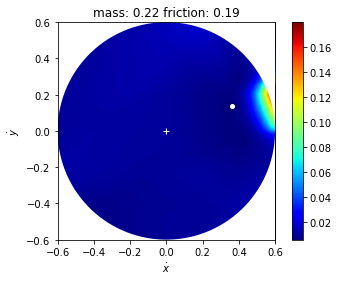

0.03149747475981712

In [90]:
class ExpectedDistanceProduction(torch.nn.Module):
    
    def __init__(self, policy, mean_model=None, variance_model=None, x_norm=None, u_norm=None, y_norm=None):
        super(ExpectedDistanceProduction, self).__init__()
        self.policy = policy
        self.mean = mean_model
        self.variance = variance_model
        self.x_norm = x_norm
        self.u_norm = u_norm
        self.g_norm = y_norm
        self.register_buffer(
            'weights',
            torch.FloatTensor([1.0, 1.0, 0.1, 0.1])
        )
        
    def forward(self, x, g):
        """
        Variables should not be normalized!
        Goal is relative object! G_rel = (G - X)
        Goal is normalized with same as Y = (X' - X)
        """
        x = self.x_norm(x)
        g = self.g_norm(g)
        u = self.u_norm(self.policy(x, g))
        mean = self.mean(x, u)
        var = self.variance(x, u)
        return ((var + (mean - g) ** 2) * Variable(self.weights)).sum(dim=1)
    
    
edp = ExpectedDistanceProduction(π, mean_model=reward, variance_model=variance, x_norm=norm_x, u_norm=norm_u, y_norm=norm_y).cuda()
X, U, G = next(iter(dataloader_val))
X, U, G = map(lambda x: Variable(x.cuda()), [X, U, G])
#X = Variable(torch.cuda.FloatTensor([[0.0, 0.2, 0.0, 0.1, 0.1, 0.05, 0.05]]))
#G = Variable(torch.cuda.FloatTensor([[0.0, 0.1, 0.0]]))
plot_q(X=X, G=G, π=π)
edp.cpu()
#with open('saved_models/expected_distance.pkl', 'wb') as f:
#    pickle.dump(edp.state_dict(), f)
edp.cuda()
edp(X[:1, :], G[:1, :]).cpu().data[0]

/home/isacar/workspace/oracle_server/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


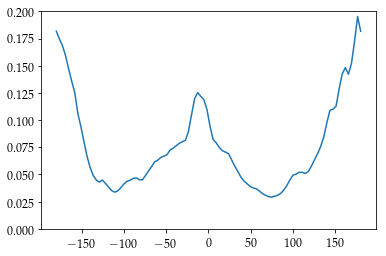

In [351]:
θs = np.linspace(-np.pi, np.pi, 100)
ys = []
for θ in θs:
    d = 0.2
    gd = 0.4
    X = Variable(torch.cuda.FloatTensor([[np.cos(θ) * d, np.sin(θ) * d, 0.0, 0.1, 0.1, 0.2, 0.2]]))
    G = Variable(torch.cuda.FloatTensor([[np.cos(θ) * gd, np.sin(θ) * gd, 1.0, 0.0]]))
    ys.append(edp(X, G).cpu().data.numpy()[0])
plt.plot(θs / np.pi * 180, ys)
plt.ylim(0.0, 0.2)
plt.show()

In [26]:
print(dataset[['w', 'h', 'm', 'µ']].min())
print(dataset[['w', 'h', 'm', 'µ']].max())

w    0.080502
h    0.080502
m    0.100451
µ    0.100045
dtype: float64
w    0.119970
h    0.119970
m    0.199695
µ    0.199982
dtype: float64


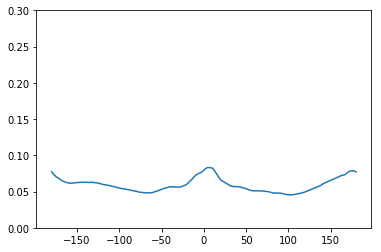

In [28]:
θs = np.linspace(-np.pi, np.pi, 256)
ys = []
θ_obj = 90 / 180 * np.pi
d = 0.2
k = 0.4
m = 0.1
µ = 0.2
w = h = 0.1
for θ in θs:
    X = Variable(torch.cuda.FloatTensor([[np.cos(θ) * d, np.sin(θ) * d, 0.0, w, h, m, µ]]))
    U = Variable(torch.cuda.FloatTensor([[k * np.cos(θ), k * np.sin(θ), 0.0, 0.4]]))
    #U = Variable(torch.cuda.FloatTensor([[k * np.cos(θ_obj), k * np.sin(θ_obj), 0.0, 0.6]]))
    ys.append(((norminv_y(variance(norm_x(X), norm_u(U)) ** 0.5)) ** 2)[0, :2].sum().data[0] ** 0.5)
plt.ylim(0.0, 0.3)
plt.plot(180 * θs / np.pi, ys)
plt.show()

# Closed form of MCMC
- obj   : (width, height, mass, friction, dx, dy, dθ)
- robot : (x_robot, y_robot, θ_robot)

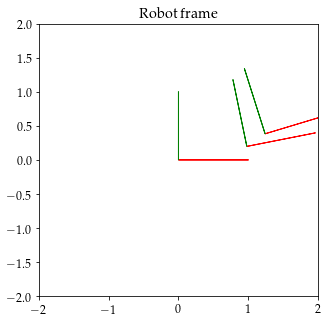

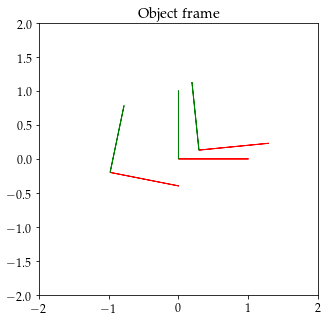

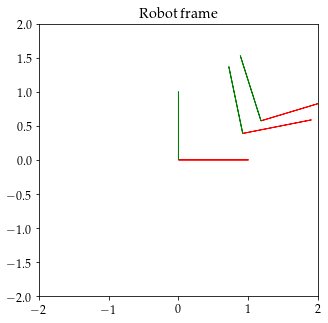

In [171]:
def to_object_centric(X, Y):
    """
    X : (obj_x, obj_y, obj_θ, width, height, mass, friction)
    Y : (obj_x', obj_y', cos(obj_θ'), sin(obj_θ'))
    returns (width, height, mass, friction, x', y', θ'), all in object frame
    """
    res = torch.zeros(X.size(0), 7)
    if X.is_cuda:
        res = res.cuda()
    res[:, 0] = X[:, 3] # width
    res[:, 1] = X[:, 4] # height
    res[:, 2] = X[:, 5] # mass
    res[:, 3] = X[:, 6] # friction
    θ = X[:, 2]
    θ_ = torch.atan2(Y[:, 3], Y[:, 2])
    # translate object successor state
    Y_t = Y[:, :2] - X[:, :2]
    res[:, 4] = Y_t[:, 0] * torch.cos(θ) + Y_t[:, 1] * torch.sin(θ)
    res[:, 5] = -Y_t[:, 0] * torch.sin(θ) + Y_t[:, 1] * torch.cos(θ)
    res[:, 6] = torch.atan2(torch.sin(θ_ - θ), torch.cos(θ_ - θ))
    return res
        
def to_robot_centric(robot, obj):
    """
    Expects (in object centric frame):
    robot : (x_robot, y_robot, θ_robot)
    obj   : (width, height, mass, friction, x', y', θ')
    
    Returns (in robot frame):
    X : (obj_x, obj_y, obj_θ, width, height, mass, friction)
    Y : (obj_x', obj_y', cos(obj_θ'), sin(obj_θ'))
    """
    X = Variable(torch.zeros(robot.size(0), 7))
    Y = Variable(torch.zeros(robot.size(0), 4))
    if robot.is_cuda:
        X = X.cuda()
        Y = Y.cuda()
    θr = robot[:, 2]
    θo = obj[:, -1]
    X[:, 0] = -robot[:, 0] * torch.cos(θr) - robot[:, 1] * torch.sin(θr)
    X[:, 1] = robot[:, 0] * torch.sin(θr) - robot[:, 1] * torch.cos(θr)
    X[:, 2] = torch.atan2(torch.sin(-θr), torch.cos(-θr))
    X[:, 3] = obj[:, 0] # width
    X[:, 4] = obj[:, 1] # height
    X[:, 5] = obj[:, 2] # mass
    X[:, 6] = obj[:, 3] # friction
    Y[:, 0] = obj[:, 4] * torch.cos(θr) + obj[:, 5] * torch.sin(θr) + X[:, 0]
    Y[:, 1] = -obj[:, 4] * torch.sin(θr) + obj[:, 5] * torch.cos(θr) + X[:, 1]
    Y[:, 2] = torch.cos(θo - θr)
    Y[:, 3] = torch.sin(θo - θr)
    return X, Y

def plot_robot_frame(X, Y):
    fig = plt.figure(figsize=(5, 5))
    plt.title('Robot frame')
    plt.arrow(0, 0, 1.0, 0.0, color='red')
    plt.arrow(0, 0, 0.0, 1.0, color='green')
    plt.arrow(X[0, 0], X[0, 1], np.cos(X[0, 2]), np.sin(X[0, 2]), color='red')
    plt.arrow(X[0, 0], X[0, 1], -np.sin(X[0, 2]), np.cos(X[0, 2]), color='green')
    plt.arrow(Y[0, 0], Y[0, 1], Y[0, 2], Y[0, 3], color='red')
    plt.arrow(Y[0, 0], Y[0, 1], -Y[0, 3], Y[0, 2], color='green')
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.show()
    
def plot_object_frame(O, R):
    fig = plt.figure(figsize=(5, 5))
    plt.title('Object frame')
    plt.arrow(0, 0, 1.0, 0.0, color='red')
    plt.arrow(0, 0, 0.0, 1.0, color='green')
    plt.arrow(R.data[0, 0], R.data[0, 1], np.cos(R.data[0, 2]), np.sin(R.data[0, 2]), color='red')
    plt.arrow(R.data[0, 0], R.data[0, 1], -np.sin(R.data[0, 2]), np.cos(R.data[0, 2]), color='green')
    plt.arrow(O.data[0, -3], O.data[0, -2], np.cos(O.data[0, -1]), np.sin(O.data[0, -1]), color='red')
    plt.arrow(O.data[0, -3], O.data[0, -2], -np.sin(O.data[0, -1]), np.cos(O.data[0, -1]), color='green')
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.show()

X, U, Y = next(iter(dataloader_val))
Y = Y.cuda()
r_d = 1.0
r_d_ = 1.3
θ_dir = 0.2
θ_dir_ = 0.3
θ_obj = 0.2
θ_obj_ = 0.3
# Create variables
X = torch.cuda.FloatTensor([[r_d * np.cos(θ_dir), r_d * np.sin(θ_dir), θ_obj, 0.1, 0.2, 0.3, 0.4]])
Y = torch.cuda.FloatTensor([[r_d_ * np.cos(θ_dir_), r_d_ * np.sin(θ_dir_), np.cos(θ_obj_), np.sin(θ_obj_)]])
plot_robot_frame(X, Y)

O = Variable(to_object_centric(X[:1, :], Y[:1, :]))
R = Variable(torch.cuda.FloatTensor([[-r_d * np.cos(θ_dir), -r_d * np.sin(θ_dir), -θ_obj]]))
plot_object_frame(O, R)

X, Y = to_robot_centric(R, O)
plot_robot_frame(X.data, Y.data)

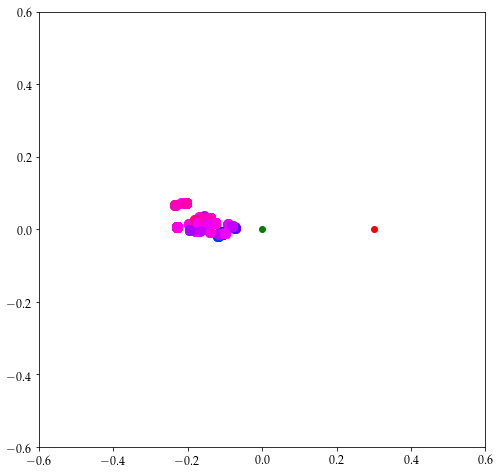

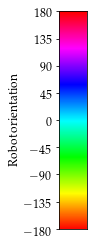

In [188]:
class ObjectCentric2Energy(torch.nn.Module):
    
    def __init__(self, expected_distance_production):
        super(ObjectCentric2Energy, self).__init__()
        self.edp = expected_distance_production
        
    def forward(self, rob, obj):
        X, Y = to_robot_centric(rob, obj)
        U = edp(X, Y)
        return U

edp.eval()
energy = ObjectCentric2Energy(edp.cuda())
energy = energy.cuda()

def initial_robot(obj):
    """
    Proposes initial robot mcmc-particle
    obj   : (width, height, mass, friction, dx, dy, dθ)
    robot : (x_robot, y_robot, θ_robot)
    """
    n = obj.size(0)
    rob = torch.zeros(n, 3)
    rob[:, :2] = torch.randn(n, 2) * 0.01
    rob[:, -1] = (2 * torch.rand(n, 1) - 1) * np.pi
    if obj.is_cuda:
        return rob.cuda()
    else:
        return rob
    
def jump(rob):
    """
    Proposes next robot mcmc-particle
    robot : (x_robot, y_robot, θ_robot)
    """
    n = rob.size(0)
    rob_ = rob.clone()
    rob_[:, :2] += torch.randn(n, 2).cuda() * 0.05
    rob_[:, -1:] += torch.randn(n, 1).cuda() * 0.5
    rob_[:, -1:] = torch.atan2(torch.sin(rob_[:, -1]), torch.cos(rob_[:, -1]))
    return rob_

logger = SummaryWriter('./runs/dual-point-data-gen')
step = 0

plt.close()
plot = True
i = np.random.randint(0, 256)
i = 0
#dataset_feasibility = []
for X, U, Y in dataloader_train:
    r_d = 0.0
    θ_dir = 0.0
    θ_obj = θ_obj_ = 0.0
    r_d_ = 0.3
    θ_dir_ = 0.0
    X = torch.cuda.FloatTensor([[r_d * np.cos(θ_dir), r_d * np.sin(θ_dir), θ_obj, 0.1, 0.1, 0.1, 0.1]])
    Y = torch.cuda.FloatTensor([[r_d_ * np.cos(θ_dir_), r_d_ * np.sin(θ_dir_), np.cos(θ_obj_), np.sin(θ_obj_)]])
    n = X.size(0)
    obj = to_object_centric(X, Y).cuda()
    rob = initial_robot(obj)
    n_timesteps = 400
    for t in range(n_timesteps):
        X, Y = to_robot_centric(Variable(rob), Variable(obj))
        e = edp(X, Y)
        rob_ = jump(rob)
        X_, Y_ = to_robot_centric(Variable(rob_), Variable(obj))
        e_ = edp(X_, Y_)
        u = torch.rand(n, 1).cuda()
        temp = 128
        α = torch.exp(temp * (e.data - e_.data)).view(-1, 1)
        accept = (u < α).float()
        rob = accept * rob_ + (1 - accept) * rob
        if plot and t == 0:
            plt.figure(figsize=(8, 8))
            plt.plot(0, 0, 'go')
            plt.plot(obj[i, -3], obj[i, -2], 'ro')
        if t > 100:
            rob_np = np.zeros((n, 4))
            rob_np[:, :2] = rob.cpu().numpy()[:, :2]
            rob_np[:, 2] = np.cos(rob.cpu().numpy()[:, -1])
            rob_np[:, 3] = np.sin(rob.cpu().numpy()[:, -1])
            θ = rob[i, -1]
            if plot:
                hue = (θ + np.pi) / (2 * np.pi)
                plt.plot(rob_np[i, 0], rob_np[i, 1], '.', color=hsv_to_rgb((hue, 1, 1.0)), markersize=20.0)
            dataset_feasibility.extend([(o.cpu().numpy(), r) for o, r in zip(obj, rob_np)])
            #logger.add_scalar('n_samples', len(dataset_feasibility), step)
            step += 1
    break
    #if len(dataset_feasibility) > 2000000:
    #    break

if plot:
    plt.xlim(-0.6, 0.6)
    plt.ylim(-0.6, 0.6)
    plt.show()
    plt.figure(figsize=(0.5, 4))
    for θ in np.linspace(-np.pi, np.pi, 640):
        hue = (θ + np.pi) / (2 * np.pi)
        plt.plot([0, 0.1], [θ / np.pi * 180] * 2, color=hsv_to_rgb((hue, 1, 1.0)), markersize=1)
    plt.ylim([-180, 180])
    plt.yticks([-180, -135, -90, -45, 0, 45, 90, 135, 180])
    plt.xticks([])
    plt.ylabel('Robot orientation')
    plt.show()

In [187]:
with open('./dataset_feasibility_dot.pkl', 'wb') as f:
    pickle.dump(dataset_feasibility, f)
#with open('./dataset_feasibility.pkl', 'rb') as f:
#    dataset_feasibility = pickle.load(f)
len(dataset_feasibility)

98304

In [329]:
# obj   : (width, height, mass, friction, dx, dy, dθ)
# robot : (x_robot, y_robot, θ_robot)
#np.array([sample[0] for sample in dataset_feasibility[:1000]]).std(axis=0).reshape(1, -1)
np.array([sample[1] for sample in dataset_feasibility[:1000]]).max(axis=0).reshape(1, -1)

array([[1.16729033, 0.89244407, 0.99999994, 0.99999934]])

In [330]:
# Normalize target distribution
robot_norm = Normalization(4)
robot_norm.std = torch.cuda.FloatTensor([1.2, 1.2, 1.0, 1.0]) # picked by eyeballing, first two are maximum

robot_norminv = NormalizationInverse(4)
robot_norminv.std = robot_norm.std

robot_norm = robot_norm.cuda()
robot_norminv = robot_norminv.cuda()

# Normalize input data
obs_norm = Normalization(7)
obs_mean = np.array([sample[0] for sample in dataset_feasibility[:1000]]).mean(axis=0)
obs_std = np.array([sample[0] for sample in dataset_feasibility[:1000]]).std(axis=0)
obs_norm.mean = torch.from_numpy(obs_mean).float().cuda()
obs_norm.std = torch.from_numpy(obs_std).float().cuda()

obs_norminv = NormalizationInverse(7)
obs_norminv.mean = obs_norm.mean
obs_norminv.std = obs_norm.std

obs_norm = obs_norm.cuda()
obs_norminv = obs_norminv.cuda()

In [340]:
class FeasibilityGenerator(torch.nn.Module):
    
    def __init__(self):
        super(FeasibilityGenerator, self).__init__()
        observation_size = 7
        output_size = 4
        self.latent_size = 5
        hidden_size = 512
        input_size = self.latent_size + observation_size
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.norm2 = torch.nn.BatchNorm1d(hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.norm3 = torch.nn.BatchNorm1d(hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, hidden_size)
        self.norm4 = torch.nn.BatchNorm1d(hidden_size)
        self.fc4 = torch.nn.Linear(hidden_size, hidden_size)
        self.fcy = torch.nn.Linear(hidden_size, output_size)
        self.train()
    
    def forward(self, obj):
        """
        Expects obj: (width, height, dx, dy, dθ)
        """
        z = Variable(torch.randn(obj.size(0), self.latent_size))
        if obj.is_cuda:
            z = z.cuda()
        inputs = torch.cat([obj, z], dim=1)
        y1 = self.fc1(inputs)
        y2 = self.fc2(F.relu(self.norm2(y1))) + y1
        y3 = self.fc3(F.relu(self.norm3(y2))) + y2
        y4 = self.fc4(F.relu(self.norm4(y3))) + y3
        y = F.tanh(self.fcy(y4))
        return y


class Discriminator(torch.nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        input_size = 7 + 4
        hidden_size = 512
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc4 = torch.nn.Linear(hidden_size, hidden_size)
        self.fcy = torch.nn.Linear(hidden_size, 1)
        self.train()
        
    def forward(self, obj, rob):
        inputs = torch.cat([obj, rob], dim=1)
        y1 = self.fc1(inputs)
        y2 = self.fc2(F.relu(y1)) + y1
        y3 = self.fc3(F.relu(y2)) + y2
        y4 = self.fc4(F.relu(y3)) + y3
        logit = self.fcy(y4)
        y = F.sigmoid(logit)
        return logit, y
    
generator = FeasibilityGenerator()

In [118]:
def configure_latex():
    """ 
        Configure matplotlib to use latex in a pretty way
    """
    plt.rcParams.update({
        'font.family': 'sans',
        'font.serif': 'Palatino',
        'font.size': 12, 
        'legend.fontsize': 14, 
        'legend.labelspacing': 0,
        'text.usetex': True,
        'savefig.dpi': 300})


def simplify_axis(axis):
    """ 
        Simplify axis
    """
    axis.set_frame_on(False)
    xmin, xmax = axis.get_xaxis().get_view_interval()
    ymin, ymax = axis.get_yaxis().get_view_interval()
    axis.add_artist(plt.Line2D((xmin, xmin), (ymin, ymax), color='black',
                               linewidth=1, zorder=100, clip_on=False))
    axis.add_artist(plt.Line2D((xmin, xmax), (ymin, ymin), color='black',
                               linewidth=1, zorder=100, clip_on=False))
    axis.get_yaxis().tick_left()
    axis.get_xaxis().tick_bottom()


def save_fig(fig_name, width=9, height=5):
    """ 
        Save the current figure under filename fig_name
    """
    plt.gcf().set_size_inches((width, height))
    simplify_axis(plt.gca())
    plt.savefig(fig_name, bbox_inches='tight', pad_inches=0.02)
    plt.close()
    
configure_latex()

In [342]:
dataset.head()

,x0,x1,x2,y0,y1,y2,x_0,x_1,x_2,y_0,...,u1,u2,u3,u4,w,h,m,I,µ,type
5,0,0,0,-0.032251,0.384002,2.222710,-0.183518,0.174064,-1.084980,-0.032251,...,0.167967,-1.050920,0.292832,0.01,0.108336,0.108336,0.152923,0.000202,0.104125,Octaeder
6,0,0,0,0.049536,-0.225697,-0.105058,-0.039715,0.603732,1.132510,0.049536,...,0.497471,0.938167,0.547183,0.01,0.101483,0.101483,0.188412,0.000219,0.168267,Octaeder
7,0,0,0,-0.048466,0.129591,0.314218,-0.475279,0.179233,-1.056290,-0.048466,...,0.173073,-1.027250,0.305390,0.01,0.098693,0.098693,0.190360,0.000209,0.128066,Octaeder
15,0,0,0,-0.465138,-0.185059,1.127320,0.367503,-0.093942,-0.093196,-0.465138,...,-0.129031,-0.128457,0.475490,0.01,0.107839,0.107839,0.116689,0.000153,0.192796,Octaeder
20,0,0,0,0.029955,-0.241780,-0.859790,0.106801,-0.255355,0.063953,0.063409,...,-0.517061,0.562199,0.095095,0.52,0.104455,0.104455,0.131438,0.000162,0.104246,Octaeder


/home/isacar/workspace/oracle_server/venv/lib/python3.5/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (48) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/palatino/uplr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/isacar/workspace/oracle_server/venv/lib/python3.5/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (46) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/palatino/uplr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/isacar/workspace/oracle_server/venv/lib/python3.5/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (53) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/palatino/uplr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/isacar/workspace/oracle_server/venv/lib/python3.5/site-packages/matplotlib/text

KeyboardInterrupt: 

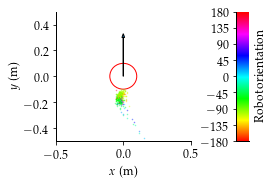

In [166]:
def plot_generator(generator, iteration, path=None, k=0.3):
    generator.eval()
    n = 400
    os = [
        Variable(torch.FloatTensor([[0.1, 0.1, 0.2, 0.2, 1.00 * 0, 1.00 * k, 0.0]]).cuda().repeat(n, 1)),
        #Variable(torch.FloatTensor([[0.1, 0.1, 0.1, 0.1, 1.00 * k, 1.00 * 0, 0.0]]).cuda().repeat(n, 1)),
        #Variable(torch.FloatTensor([[0.1, 0.1, 0.1, 0.1, 1.00 * 0,-1.00 * k, 0.0]]).cuda().repeat(n, 1)),
        #Variable(torch.FloatTensor([[0.1, 0.1, 0.1, 0.1,-1.00 * k, 1.00 * 0, 0.0]]).cuda().repeat(n, 1)),
    ]
    frg_w, fig_h = 3.4, 2.5
    fig, axs = plt.subplots(1, 2, figsize=(fig_w, fig_h), gridspec_kw={'width_ratios': [1, 0.1]})
    axs = axs.flatten()
    plt.tight_layout()
    circle = plt.Circle((0, 0), 0.1, fill=False, color='red')
    axs[0].add_artist(circle)
    for i in range(1):
        O = obs_norm(os[i])
        r = robot_norminv(generator(O)).cpu().data.numpy()
        for j in range(r.shape[0]):
            θ = np.arctan2(r[j, -1], r[j, -2])
            hue = (θ + np.pi) / (2 * np.pi)
            hue = (hue + 0.25) % 1.0
            axs[i].plot(r[j, 0], r[j, 1], 'o', color=hsv_to_rgb((hue, 1, 1.0)), markersize=0.5, alpha=0.5)
        axs[i].arrow(0, 0, os[i].data[0, 4], os[i].data[0, 5], head_width=0.02)
        axs[i].set_xlim(-0.5, 0.5)
        axs[i].set_ylim(-0.5, 0.5)
        axs[i].set_xlabel('$x$ (m)')
        simplify_axis(axs[i])
    axs[0].set_ylabel('$y$ (m)')
        
    # degree bar
    for θ in np.linspace(-np.pi, np.pi, 640):
        hue = (θ + np.pi) / (2 * np.pi)
        axs[1].plot([0, 0.1], [θ / np.pi * 180] * 2, color=hsv_to_rgb((hue, 1, 1.0)), markersize=1)
    axs[1].set_ylim([-180, 180])
    axs[1].set_yticks([-180, -135, -90, -45, 0, 45, 90, 135, 180])
    axs[1].set_xticks([])
    axs[1].set_ylabel('Robot orientation')
    axs[1].yaxis.set_label_position("right")
    
    if path:
        save_fig(path, width=fig_w, height=fig_h)
        plt.show()
    else:
        plt.show()
    generator.train()

plt.close()
i = 47
with open('./generator_models/dual-point/model_{}000.pkl'.format(i), 'rb') as f:
    state_dict = torch.load(f)
generator.load_state_dict(state_dict)
generator = generator.cuda()
plot_generator(generator, 30000, path='/home/isacar/workspace/ra-l-2017-rearrangement/paper/figures/gan-samples-dual-point.svg')
#plot_generator(generator, 30000)

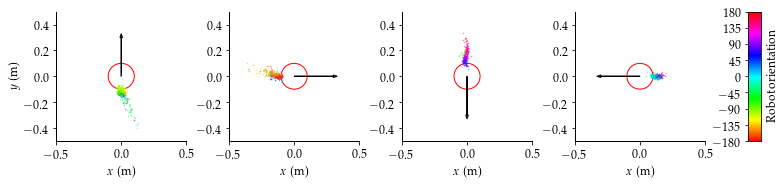

In [196]:
def plot_generator(generator, iteration, path=None, k=0.3):
    generator.eval()
    n = 400
    os = [
        Variable(torch.FloatTensor([[0.1, 0.1, 0.1, 0.1, 1.00 * 0, 1.00 * k, 0.0]]).cuda().repeat(n, 1)),
        Variable(torch.FloatTensor([[0.1, 0.1, 0.1, 0.1, 1.00 * k, 1.00 * 0, 0.0]]).cuda().repeat(n, 1)),
        Variable(torch.FloatTensor([[0.1, 0.1, 0.1, 0.1, 1.00 * 0,-1.00 * k, 0.0]]).cuda().repeat(n, 1)),
        Variable(torch.FloatTensor([[0.1, 0.1, 0.1, 0.1,-1.00 * k, 1.00 * 0, 0.0]]).cuda().repeat(n, 1)),
    ]
    fig_w, fig_h = 10.5, 2.5
    fig, axs = plt.subplots(1, 5, figsize=(fig_w, fig_h), gridspec_kw={'width_ratios': [1, 1, 1, 1, 0.1]})
    axs = axs.flatten()
    plt.tight_layout()
    for i in range(4):
        circle = plt.Circle((0, 0), 0.1, fill=False, color='red')
        axs[i].add_artist(circle)
        O = obs_norm(os[i])
        r = robot_norminv(generator(O)).cpu().data.numpy()
        for j in range(r.shape[0]):
            θ = np.arctan2(r[j, -1], r[j, -2])
            hue = (θ + np.pi) / (2 * np.pi)
            hue = (hue + 0.25) % 1.0
            axs[i].plot(r[j, 0], r[j, 1], 'o', color=hsv_to_rgb((hue, 1, 1.0)), markersize=0.5, alpha=0.5)
        axs[i].arrow(0, 0, os[i].data[0, 4], os[i].data[0, 5], head_width=0.02)
        axs[i].set_xlim(-0.5, 0.5)
        axs[i].set_ylim(-0.5, 0.5)
        axs[i].set_xlabel('$x$ (m)')
        simplify_axis(axs[i])
    axs[0].set_ylabel('$y$ (m)')
        
    # degree bar
    for θ in np.linspace(-np.pi, np.pi, 640):
        hue = (θ + np.pi) / (2 * np.pi)
        axs[4].plot([0, 0.1], [θ / np.pi * 180] * 2, color=hsv_to_rgb((hue, 1, 1.0)), markersize=1)
    axs[4].set_ylim([-180, 180])
    axs[4].set_yticks([-180, -135, -90, -45, 0, 45, 90, 135, 180])
    axs[4].set_xticks([])
    axs[4].set_ylabel('Robot orientation')
    axs[4].yaxis.set_label_position("right")
    
    if path:
        save_fig(path, width=fig_w, height=fig_h)
        plt.show()
    else:
        plt.show()
    generator.train()

plt.close()
i = 63
with open('./generator_models/dual-point/model_{}000.pkl'.format(i), 'rb') as f:
    state_dict = torch.load(f)
generator.load_state_dict(state_dict)
generator = generator.cuda()
plot_generator(generator, 30000, path='dual-point-gans.pdf')
plot_generator(generator, 30000)

In [111]:
print('hello')

hello


/home/isacar/workspace/oracle_server/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


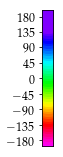

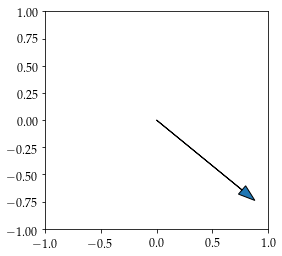

In [344]:
plt.figure(figsize=(0.2, 2.5))
for θ in np.linspace(-np.pi, np.pi):
    hue = (θ + np.pi) / (2 * np.pi)
    hue = (hue - 0.25) % 1.0
    plt.plot(0, θ / np.pi * 180, 'o', color=hsv_to_rgb((hue, 1, 1.0)), markersize=32)
plt.yticks([-180, -135, -90, -45, 0, 45, 90, 135, 180])
plt.xticks([])
plt.show()
test_angle = -130
θ = test_angle / 180 * np.pi
plt.figure(figsize=(4, 4))
plt.arrow(0.0, 0.0, -np.sin(θ), np.cos(θ), head_width=0.1)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()


In [345]:
lr = 1e-4
gamma = 1
batch_size = 256
n_steps = 100000

generator = FeasibilityGenerator().cuda()
generator_opt = torch.optim.RMSprop(generator.parameters(), lr=lr, weight_decay=1e-2)

discriminator = Discriminator().cuda()
discriminator_opt = torch.optim.RMSprop(discriminator.parameters(), lr=lr)

dataloader_feasibility = DataLoader(dataset_feasibility, batch_size=batch_size, shuffle=True, drop_last=True)
logger = SummaryWriter('./runs/dual-point-gan')

replay_dataset = []
replay_dataloader = DataLoader(replay_dataset, batch_size=batch_size, shuffle=True)
generator.train()
discriminator.train()

models = dict()

all_parameters = list(generator.parameters())
all_parameters.extend(discriminator.parameters())

labels_real = Variable(torch.ones(batch_size, 1)).cuda()
labels_fake = Variable(torch.zeros(batch_size, 1)).cuda()

step = -1

i = 64000
    
while True:
    for O, R in dataloader_feasibility:
        R = R.clamp(-1, 1)
        step += 1
        R = robot_norm(Variable(R.float().cuda()))
        O = obs_norm(Variable(O.float().cuda()))

        # Train discriminator
        # - train real
        discriminator.zero_grad()
        logits, D = discriminator(O, R)
        logit_regularizer = (logits ** 2).sum() / batch_size
        loss_discriminator = -torch.log(D + 1e-6).mean()
        loss_d_real = loss_discriminator + logit_regularizer
        if step % 50 == 0:
            logger.add_scalar('discriminator real mean', D.mean().cpu().data[0], step)
        loss_d_real.backward()
        discriminator_opt.step()
        
        # - train fake
        discriminator.zero_grad()
        R_ = generator(O)
        if len(replay_dataset) > 0 and np.random.rand() < 0.5:
            o, r = next(iter(replay_dataloader))
            O_replay = Variable(o.cuda())
            R_ = Variable(r.cuda())
            logits, D = discriminator(O_replay, R_.detach())
        else:
            logits, D = discriminator(O, R_.detach())
        logit_regularizer = (logits ** 2).sum() / batch_size
        loss_discriminator = torch.log(D + 1e-6).mean()
        loss_d_real = loss_discriminator + logit_regularizer
        if step % 50 == 0:
            logger.add_scalar('discriminator fake mean', D.mean().cpu().data[0], step)
        loss_d_real.backward()
        discriminator_opt.step()

        # Train generator
        generator.zero_grad()
        R_ = generator(O)
        replay_dataset.extend(list(zip(O.data, R.data)))
        logits, D = discriminator(O, R_)
        loss_generator = -torch.log(D + 1e-6).mean()
        loss_generator.backward()
        generator_opt.step()
        
        if step % 1000 == 0:
            print('step:', step)
            plot_generator(generator, step, k=0.2, path='dual-point/sample_{}.pdf'.format(step))
            with open('./generator_models/dual-point/model_{}.pkl'.format(step), 'wb') as f:
                torch.save(generator.state_dict(), f)

        if step == n_steps - 1:
            break
    if step == n_steps - 1:
        break

step: 0


/home/isacar/workspace/oracle_server/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/isacar/workspace/oracle_server/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


step: 1000


/home/isacar/workspace/oracle_server/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


step: 2000


/home/isacar/workspace/oracle_server/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


step: 3000


/home/isacar/workspace/oracle_server/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


step: 4000


/home/isacar/workspace/oracle_server/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


step: 5000


/home/isacar/workspace/oracle_server/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


step: 6000


/home/isacar/workspace/oracle_server/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


step: 7000


/home/isacar/workspace/oracle_server/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


step: 8000


/home/isacar/workspace/oracle_server/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


step: 9000


/home/isacar/workspace/oracle_server/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


step: 10000


/home/isacar/workspace/oracle_server/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


step: 11000


/home/isacar/workspace/oracle_server/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


step: 12000


/home/isacar/workspace/oracle_server/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


step: 13000


/home/isacar/workspace/oracle_server/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


step: 14000


/home/isacar/workspace/oracle_server/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


step: 15000


/home/isacar/workspace/oracle_server/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


step: 16000


/home/isacar/workspace/oracle_server/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


step: 17000


/home/isacar/workspace/oracle_server/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


step: 18000


/home/isacar/workspace/oracle_server/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


KeyboardInterrupt: 

In [897]:
class GeneratorProduction(torch.nn.Module):
    
    def __init__(self):
        super(GeneratorProduction, self).__init__()
        self.generator = FeasibilityGenerator()
        self.obj_norm = Normalization(7)
        self.rob_norminv = NormalizationInverse(4)
    
    def forward(self, obj, obj_delta):
        """
        obj       : (width, height, mass, friction, x_obj, y_obj, θ_obj)
        obj_delta : (dx, dy, dθ)
        """
        # obj_delta' is the delta in object frame
        obj_delta_ = Variable(torch.zeros(obj.size(0), 7))
        θ = obj[:, -1]
        obj_delta_[:, :4] = obj[:, :4]
        obj_delta_[:, 4] =  torch.cos(θ) * obj_delta[:, 0] + torch.sin(θ) * obj_delta[:, 1]
        obj_delta_[:, 5] = -torch.sin(θ) * obj_delta[:, 0] + torch.cos(θ) * obj_delta[:, 1]
        obj_delta_[:, 6] = obj_delta[:, -1]
        y = self.rob_norminv(self.generator(self.obj_norm(obj_delta_)))
        y[:, 2] = torch.atan2(y[:, 3], y[:, 2])
        # invariant: y is now robot position in object frame
        # convert to robot frame
        y_rob = Variable(torch.zeros(obj.size(0), 3))
        y_rob[:, 0] = obj[:, 4] + torch.cos(θ) * y[:, 0] - torch.sin(θ) * y[:, 1]
        y_rob[:, 1] = obj[:, 5] + torch.sin(θ) * y[:, 0] + torch.cos(θ) * y[:, 1]
        θr = y[:, 2] + θ
        y_rob[:, 2] = torch.atan2(torch.sin(θr), torch.cos(θr))
        return y_rob
    

generator_production = GeneratorProduction()
generator_production.generator.load_state_dict(generator.state_dict())
generator_production.obj_norm.load_state_dict(obs_norm.state_dict())
generator_production.rob_norminv.load_state_dict(robot_norminv.state_dict())
generator_production = generator_production.cpu()
generator_production.eval()

o = Variable(torch.FloatTensor([[0.13, 0.13, 0.1, 0.1, 0.3, 0.0, np.pi / 2]]))
do = Variable(torch.FloatTensor([[-0.3, 0.0, 0.0]]))
y = generator_production(o, do).data.numpy().flatten()

with open('saved_models/generator_production.pkl', 'wb') as f:
    pickle.dump(generator_production.state_dict(), f)

In [493]:
generator.load_state_dict()

1.9007963267948966

# Pushability

$$p(x_t'|x_t)$$

## Datasets

In [ ]:
# sort in order
dataset_pushability = dataset[['y\'_0', 'y\'_1', 'y\'_2', 'm', 'I', 'µ', 'w', 'h']] # skip u_4 because always 0
dataset_pushability = dataset_pushability[(dataset_pushability[['y\'_0', 'y\'_1', 'y\'_2']].abs().max(axis=1) > 1e-1)]
# Decide where to split in training/validation/test
train_cut = int(len(dataset_pushability) * 0.9)
valid_cut = train_cut + int(len(dataset_pushability) * 0.05)
dataset_pushability_train_ = dataset_pushability[:train_cut]
dataset_pushability_val_ = dataset_pushability[train_cut:valid_cut]
dataset_pushability_test_ = dataset_pushability[valid_cut:]

## Normalize by training set statistics
training_pushability_µ = dataset_pushability_train_.mean().values.astype(np.float32)
training_pushability_σ = dataset_pushability_train_.std().values.astype(np.float32)
dataset_pushability_train = (dataset_pushability_train_ - training_pushability_µ) / training_pushability_σ
dataset_pushability_val = (dataset_pushability_train_ - training_pushability_µ) / training_pushability_σ
dataset_pushability_test = (dataset_pushability_train_ - training_pushability_µ) / training_pushability_σ

def get_dataloader(dataset, batch_size=32):
    X = dataset[[name for name in dataset.columns if not name.startswith('y\'')]]
    Y = dataset[[name for name in dataset.columns if name.startswith('y\'')]]
    return DataLoader(
        list(zip(X.as_matrix().astype(np.float32), Y.as_matrix().astype(np.float32))),
        batch_size=batch_size,
        shuffle=True
    )

dataloader_pushability_train = get_dataloader(dataset_pushability_train)
dataloader_pushability_val = get_dataloader(dataset_pushability_val, batch_size=512)
dataloader_pushability_test = get_dataloader(dataset_pushability_test, batch_size=512)
X, Y = next(iter(dataloader_pushability_train))
pushability_x_size, pushability_y_size = X.size(1), Y.size(1)

# Models:

In [ ]:
n_residual_units = 1
hidden_size = 256
X, Y = next(iter(dataloader_pushability_train))
x_size = X.size(1)
y_size = Y.size(1)
print('X and Y sizes:', x_size, y_size)
pushability_mean = torch.nn.Sequential(
    torch.nn.Linear(x_size, hidden_size),
    *[Residual(hidden_size) for _ in range(n_residual_units)],
    torch.nn.Linear(hidden_size, y_size)
).cuda()

pushability_std = torch.nn.Sequential(
    torch.nn.Linear(x_size, hidden_size),
    *[Residual(hidden_size) for _ in range(n_residual_units)],
    torch.nn.Linear(hidden_size, y_size),
    torch.nn.Softplus()
).cuda()

In [ ]:
mean_loss_fn = torch.nn.MSELoss()
mean_optim = torch.optim.Adam(pushability_mean.parameters(), weight_decay=1e-4)
var_loss_fn = gaussian_likelihood()
var_optim = torch.optim.Adam(pushability_std.parameters(), weight_decay=1e-4)

logger_train = SummaryWriter('runs/resid-1-pushability-train')
logger_valid = SummaryWriter('runs/resid-1-pushability-valid')

In [ ]:
best_val = np.inf
best_mean_model = None
best_var_model = None
step = 0
while True:
    for batch in dataloader_pushability_train:
        pushability_mean.train()
        pushability_std.train()
        X, Y = map(lambda x: torch.autograd.Variable(x.cuda()), batch)
        Y_mean_pred = pushability_mean(X)
        Y_var_pred = pushability_std(X)

        pushability_mean.zero_grad()
        pushability_std.zero_grad()

        mse = mean_loss_fn(Y_mean_pred, Y)
        mse.backward(retain_graph=True)
        mean_optim.step()

        nll = var_loss_fn(Y_mean_pred, Y_var_pred, Y)
        nll.backward()
        var_optim.step()

        if step % 10 == 0:
            logger_train.add_scalar('mse', mse.cpu().data.numpy()[0], step)
            logger_train.add_scalar('nll', nll.cpu().data.numpy()[0], step)
            
            pushability_mean.eval()
            pushability_std.eval()
            val_batch = next(iter(dataloader_pushability_val))
            X, Y = map(lambda x: torch.autograd.Variable(x.cuda()), val_batch)
            Y_mean_pred = pushability_mean(X)
            Y_var_pred = pushability_std(X)

            mse_val = mean_loss_fn(Y_mean_pred, Y)
            nll_val = var_loss_fn(Y_mean_pred, Y_var_pred, Y).cpu().data.numpy()[0]
            
            logger_valid.add_scalar('mse', mse_val.cpu().data.numpy()[0], step)
            logger_valid.add_scalar('nll', nll_val, step)
            
            if nll_val < best_val:
                best_val = nll_val
                best_mean_model = pushability_mean.state_dict()
                best_var_model = pushability_std.state_dict()

        step += 1
        if step >= 100000:
            break
    if step >= 100000:
        break

In [ ]:
X, Y = next(iter(dataloader_pushability_train))
pushability_x_size, pushability_y_size = X.size(1), Y.size(1)

pushability_norm = Normalization(5)
pushability_norm.mean = torch.from_numpy(training_pushability_μ[3:])
pushability_norm.std = torch.from_numpy(training_pushability_σ[3:])

pushability_norminv = NormalizationInverse(3)
pushability_norminv.mean = torch.from_numpy(training_pushability_μ[:3])
pushability_norminv.std = torch.from_numpy(training_pushability_σ[:3])

In [ ]:
with open('./saved_models/pushability_models.pkl', 'wb') as f:
    model_dict = {
        'mean_model': pushability_mean.state_dict(),
        'std_model': pushability_std.state_dict(),
        'norm': pushability_norm.state_dict(),
        'norm_inv': pushability_norminv.state_dict(),
        'n_features_in': pushability_x_size,
        'n_features_out': pushability_y_size,
        'n_hidden_units': 256,
        'n_residual_units': 1,
    }
    pickle.dump(model_dict, f)

In [ ]:
pushability_mean.eval()
pushability_std.eval()
pushability_mean.load_state_dict(best_mean_model)
pushability_std.load_state_dict(best_var_model)

from IPython.display import HTML
from matplotlib.animation import FuncAnimation
# First set up the figure, the axis, and the plot element we want to animate
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

res = 16
img = np.eye(res)
p1 = axs[0].imshow(img, extent=[-1, 1, -1, 1], vmin=0.0, vmax=0.5, interpolation='gaussian')
std1 = axs[0].add_artist(plt.Circle((0, 0), fill=False, color='white'))
std2 = axs[0].add_artist(plt.Circle((0, 0), fill=False, color='white'))
axs[0].set_title('Translation')
axs[2].set_title('Parameter')
axs[2].set_xlim(0, 32)
axs[2].set_ylim(0, 2.0)
θ_data = []
θ_plot, = axs[1].plot(θ_data)
axs[1].set_xlim(0, 32)
axs[1].set_ylim(0, 2)
axs[1].set_title('Rotation standard dev.')
ydata = []
argplot, = axs[2].plot(ydata)
    
# animation function. This is called sequentially
def animate(arg):
    x = (np.array([[0.35, 0.0024, 0.195 * arg * 2, 0.12, 0.12]]) - training_pushability_μ[3:]) / training_pushability_σ[3:]
    X = Variable(torch.from_numpy(x.astype(np.float32))).cuda()
    Y_mean_pred = pushability_mean(X).cpu().data.numpy()
    Y_std = pushability_std(X).cpu().data.numpy()
    
    µ = Y_mean_pred[0, :] * training_pushability_σ[:3] + training_pushability_μ[:3]
    σ = Y_std * training_pushability_σ[:3]
    Σ = np.diag(σ.flatten())

    obs = dataset_pushability_train.iloc[0].values[3:].reshape(-1, 1)
    obs[0, 0] = arg
    for i, x in enumerate(np.linspace(-1, 1, res)):
        for j, y in enumerate(np.linspace(-1, 1, res)):
            img[j, i] = multivariate_normal.pdf([x, y, 0], mean=µ.flatten(), cov=Σ)
    p1.set_data(img)
    σ_ = σ[0, :2].mean()
    std1.set_radius(σ_)
    std2.set_radius(σ_ * 2)
    ydata.append(arg)
    θ_data.append(σ[0, 2])
    argplot.set_data(range(len(ydata)), ydata)
    argplot.set_data(range(len(ydata)), ydata)
    θ_plot.set_data(range(len(θ_data)), θ_data)
    
    return p1, std1, std2, argplot, θ_plot

# call the animator. blit=True means only re-draw the parts that have changed.
anim = FuncAnimation(fig, animate, frames=np.linspace(0.0, 2.0, 32), interval=100, blit=True)
plt.close(fig)
HTML(anim.to_html5_video())

# Feasibility
Predicts $p(x_{robot}|x_{target}, x_{target}')$

In [ ]:
dataset_feasibility = dataset[['x_0', 'x_1', 'x_2', 'x_3',
                               'y_2', 'y_3', 'y\'_0', 'y\'_1', 'y\'_2',
                               'm', 'I', 'µ', 'w', 'h']]
# Decide where to split in training/validation/test
train_cut = int(len(dataset) * 0.9)
valid_cut = train_cut + int(len(dataset) * 0.05)
dataset_feasibility_train_ = dataset_feasibility[:train_cut]
dataset_feasibility_val_ = dataset_feasibility[train_cut:valid_cut]
dataset_feasibility_test_ = dataset_feasibility[valid_cut:]

# Normalize by training set statistics
training_feasibility_µ = dataset_feasibility_train_.mean()
training_feasibility_σ = dataset_feasibility_train_.std()
dataset_feasibility_train = (dataset_feasibility_train_ - training_feasibility_µ) / training_feasibility_σ
dataset_feasibility_val = (dataset_feasibility_train_ - training_feasibility_µ) / training_feasibility_σ
dataset_feasibility_test = (dataset_feasibility_train_ - training_feasibility_µ) / training_feasibility_σ

def get_dataloader(dataset, batch_size=32):
    X = dataset[[name for name in dataset.columns if not name.startswith('x')]]
    Y = dataset[[name for name in dataset.columns if name.startswith('x')]]
    return DataLoader(
        list(zip(X.as_matrix().astype(np.float32), Y.as_matrix().astype(np.float32))),
        batch_size=batch_size,
        shuffle=True
    )

dataloader_feasibility_train = get_dataloader(dataset_feasibility_train)
dataloader_feasibility_val = get_dataloader(dataset_feasibility_val, batch_size=128)
dataloader_feasibility_test = get_dataloader(dataset_feasibility_test, batch_size=128)
X, Y = next(iter(dataloader_feasibility_train))
feasibility_x_size, feasibility_y_size = X.size(1), Y.size(1)
dataset_feasibility_train.iloc[:10]

# Models:

In [ ]:
hidden_size = 256
n_residual_units = 1

feasibility_mean = torch.nn.Sequential(
    torch.nn.Linear(feasibility_x_size, hidden_size),
    *[Residual(hidden_size) for _ in range(n_residual_units)],
    torch.nn.Linear(hidden_size, feasibility_y_size)
).cuda()

feasibility_std= torch.nn.Sequential(
    torch.nn.Linear(feasibility_x_size, hidden_size),
    *[Residual(hidden_size) for _ in range(n_residual_units)],
    torch.nn.Linear(hidden_size, feasibility_y_size),
    torch.nn.Softplus()
).cuda()

In [ ]:
weight_decay = 1e-4
mean_loss_fn = torch.nn.MSELoss()
mean_optim = torch.optim.Adam(feasibility_mean.parameters(), weight_decay=weight_decay)
std_loss_fn = gaussian_likelihood()
std_optim = torch.optim.Adam(feasibility_std.parameters(), weight_decay=weight_decay)

time_str = datetime.datetime.now().strftime('%H:%M')
name = 'runs/feasibility'
logger_train = SummaryWriter(name + '-train')
logger_valid = SummaryWriter(name + '-valid')

In [ ]:
best_val = np.inf
best_mean_model = None
best_std = None
step = 0
for _ in range(1024):
    for batch in dataloader_feasibility_train:
        feasibility_mean.train()
        feasibility_std.train()
        X, Y = map(lambda x: torch.autograd.Variable(x.cuda()), batch)
        Y_mean_pred = feasibility_mean(X)
        Y_std_pred = feasibility_std(X)

        feasibility_mean.zero_grad()
        feasibility_std.zero_grad()

        mse = mean_loss_fn(Y_mean_pred, Y)
        mse.backward(retain_graph=True)
        mean_optim.step()

        nll = std_loss_fn(Y_mean_pred, Y_std_pred, Y)
        nll.backward()
        std_optim.step()

        if step % 500 == 0:
            logger_train.add_scalar('mse', mse.cpu().data.numpy()[0], step)
            logger_train.add_scalar('nll', nll.cpu().data.numpy()[0], step)
            
            feasibility_mean.eval()
            feasibility_std.eval()
            val_batch = next(iter(dataloader_feasibility_val))
            X, Y = map(lambda x: torch.autograd.Variable(x.cuda()), val_batch)
            Y_mean_pred = feasibility_mean(X)
            Y_std_pred = feasibility_std(X)

            mse_val = mean_loss_fn(Y_mean_pred, Y)
            nll_val = std_loss_fn(Y_mean_pred, Y_std_pred, Y).cpu().data.numpy()[0]
            
            logger_valid.add_scalar('mse', mse_val.cpu().data.numpy()[0], step)
            logger_valid.add_scalar('nll', nll_val, step)
            
            if nll_val < best_val:
                best_val = nll_val
                best_mean_model = feasibility_mean.state_dict()
                best_std_model = feasibility_std.state_dict()

        step += 1

In [ ]:
feasibility_norm = Normalization(feasibility_x_size).cuda()
feasibility_norm.mean = torch.FloatTensor(training_feasibility_μ[4:].values).cuda()
feasibility_norm.std = torch.FloatTensor(training_feasibility_σ[4:].values).cuda()
feasibility_norminv = Normalization(feasibility_y_size).cuda()
feasibility_norminv.mean = torch.FloatTensor(training_feasibility_μ[:4].values).cuda()
feasibility_norminv.std = torch.FloatTensor(training_feasibility_σ[:4].values).cuda()

In [ ]:
from matplotlib.patches import Ellipse

feasibility_mean.load_state_dict(best_mean_model)
feasibility_std.load_state_dict(best_std_model)
feasibility_mean.eval()
feasibility_std.eval()

#with open('./saved_models/feasibility_models.pkl', 'wb') as f:
#    model_dict = {
#        'mean_model': feasibility_mean.state_dict(),
#        'std_model': feasibility_std.state_dict(),
#        'norm': feasibility_norm.state_dict(),
#        'norm_inv': feasibility_norminv.state_dict(),
#        'n_features_in': feasibility_x_size,
#        'n_features_out': feasibility_y_size,
#        'n_hidden_units': 256,
#        'n_residual_units': 1,
#    }
#    pickle.dump(model_dict, f)

fig, ax = plt.subplots(figsize=(6, 6))
row = dataset.sample(n=1).iloc[0]
#val_batch = next(iter(dataloader_feasibility_val))
print(row)
X = Variable(torch.cuda.FloatTensor([
    row[['y_2', 'y_3', 'y\'_0', 'y\'_1', 'y\'_2', 'm', 'I', 'µ', 'w', 'h']]
]))
#X, Y = map(lambda x: torch.autograd.Variable(x.cuda()), val_batch)
Y_mean_pred = feasibility_mean(feasibility_norm(X))
Y_std_pred = feasibility_std(feasibility_norm(X))
for _ in range(512):
    y_ = feasibility_norminv(Y_mean_pred + Y_std_pred * Variable(torch.randn(Y_mean_pred.size())).cuda())
    y = y_.cpu().data.numpy().flatten()
    plt.plot(y[0], y[1], 'bo', alpha=0.1)
plt.arrow(0, 0, row['y\'_0'], row['y\'_1'], head_width=0.05)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()

In [ ]:
training_µ